# Introduction

In this project we will create a model to predict apartment prices in the city of Buenos Aires, Argentina, where I currently live. We will focus on apartments that cost less than $400.000 USD.

We will make 4 different models, price prediction with:

1. Size - Linear regression
2. Location: latitude and longitude - Linear regression
3. Neighborhood - Ridge regression
4. Size, location and neighborhood - Ridge regression

In addition, we will make different types of visualizations throughout the project to better understand the data.

# Import libraries

In [123]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

import numpy as np
import plotly.express as px
import plotly.graph_objects as go


warnings.simplefilter(action="ignore", category=FutureWarning)


# Data Preparation

Automating data importing and cleaning process

In [124]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
   
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop low and high cardinality categorical variables
    df.drop(columns=["operation","property_type","currency","properati_url"],inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[
                     'price',
                     'price_aprox_local_currency',
                     'price_per_m2',
                     'price_usd_per_m2',
                     ],
                    inplace=True
           )
    # Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2","rooms"], inplace=True)
 

    return df


In [125]:
# Creating a list that contains all filenames in the directory and assigning the list to variable files

files = glob("buenos-aires-real-estate-*.xlt")
files

['buenos-aires-real-estate-1.xlt',
 'buenos-aires-real-estate-2.xlt',
 'buenos-aires-real-estate-3.xlt',
 'buenos-aires-real-estate-4.xlt',
 'buenos-aires-real-estate-5.xlt']

In [126]:
# Creating list that contains cleaned DataFrames for the filenames in files

frames = [wrangle(file) for file in files]
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [127]:
#Concatenate items in frames into a single DataFrame

df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6609 non-null   float64
 1   surface_covered_in_m2  6609 non-null   float64
 2   lat                    6355 non-null   float64
 3   lon                    6355 non-null   float64
 4   neighborhood           6609 non-null   object 
dtypes: float64(4), object(1)
memory usage: 258.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


# Exploring data

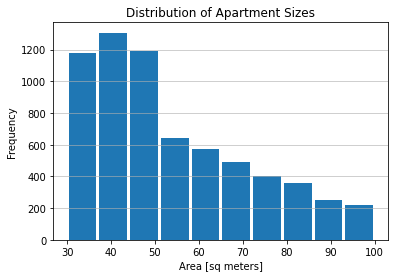

In [128]:
# Histogram of "surface covered in m2"

plt.hist(df["surface_covered_in_m2"], bins=10, rwidth=0.9)
plt.title("Distribution of Apartment Sizes")
plt.xlabel("Area [sq meters]")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75);


We can see in this image the distribution of apartment sizes in our dataset. The area of the apartments in Capital Federal is mostly between 30 and 50 m2.

In [129]:
df.describe()["surface_covered_in_m2"]

count    6609.000000
mean       53.494931
std        17.939138
min        30.000000
25%        39.000000
50%        48.000000
75%        65.000000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

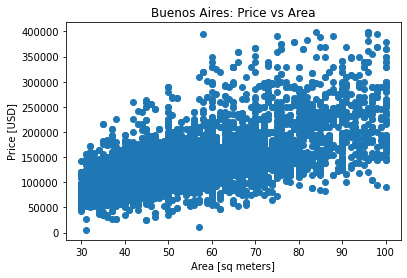

In [130]:
# Scatter plot that shows Price vs Area 

plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if we want to predict price, size will be a good feature to include.

In [131]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [132]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="lat",
    y="lon",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()

# 1. Model Building - Price and size 

## Split 

Separating target (what we want to predict) from features (information our model will use to make predictions)

In [133]:
features = ["surface_covered_in_m2"]

X_train = df[features]

X_train.shape

(6609, 1)

In [134]:
target = "price_aprox_usd"

y_train = df[target]

y_train

0       129000.0
1        87000.0
2       118000.0
3        57000.0
4        90000.0
          ...   
6604    290000.0
6605    150000.0
6606     65000.0
6607     91440.0
6608     89000.0
Name: price_aprox_usd, Length: 6609, dtype: float64

## Baseline Model

In [135]:
y_mean = y_train.mean()

print(y_mean)

132392.63490694508


In [136]:
y_pred_baseline = [y_mean]*len(y_train)

len(y_pred_baseline)==len(y_train)

True

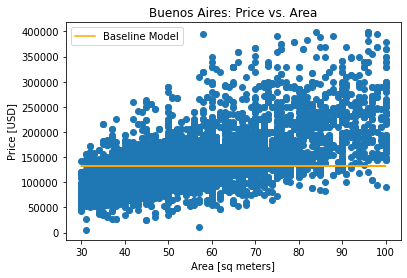

In [137]:
plt.plot(X_train, y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [138]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline Mean Absolute Error:", round(mae_baseline, 2))

Mean apt price 132392.63
Baseline Mean Absolute Error: 44765.24


## Linear Regression Model


In [139]:
model = LinearRegression()

In [140]:
# Fit predictor to data
model.fit(X_train, y_train)

LinearRegression()

### Model Evaluation

In [141]:
y_pred_training = model.predict(X_train)

y_pred_training[:5]

array([169867.08596763, 106293.60805485, 133539.38430318, 106293.60805485,
       124457.45888707])

In [142]:
mae_training = mean_absolute_error(y_train, y_pred_training)

print("Mean apt price", round(y_mean, 2))
print("Training Mean Absolute Error:", round(mae_training, 2))

Mean apt price 132392.63
Training Mean Absolute Error: 30371.22


Our model beat the baseline by over $10.000. Now, we will check how the model performs on the test set.

In [143]:
X_test = pd.read_excel("buenos-aires-test-features.xlt")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117646.014825
1    135809.865657
2     88129.757223
3     88129.757223
4    106293.608055
dtype: float64

## Results

In [144]:
intercept = model.intercept_
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 10933.391185693545


In [145]:
coefficient = round(model.coef_[0],2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2270.48


In [146]:
print(f"apt_price = {intercept} + {coefficient} * surface_covered")

apt_price = 10933.391185693545 + 2270.48 * surface_covered


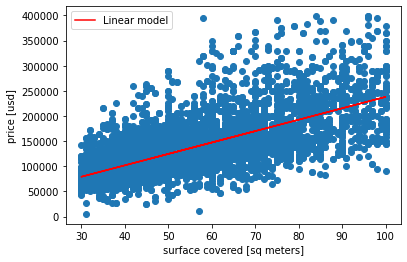

In [147]:
plt.plot(X_train, model.predict(X_train), color="r", label="Linear model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();

# 2. Model Building - Price and Location 

## Split

In [148]:
features = ["lon", "lat"]
X_train = df[features]
X_train.info

<bound method DataFrame.info of             lon        lat
0    -58.454693 -34.584651
1    -58.500115 -34.638979
2    -58.459957 -34.615847
3    -58.382382 -34.625222
4    -58.412511 -34.610610
...         ...        ...
6604 -58.519666 -34.639528
6605 -58.416439 -34.597825
6606 -58.490739 -34.652233
6607 -58.500180 -34.648761
6608 -58.387360 -34.620384

[6609 rows x 2 columns]>

In [149]:
target = "price_aprox_usd"
y_train = df[target]
y_train

0       129000.0
1        87000.0
2       118000.0
3        57000.0
4        90000.0
          ...   
6604    290000.0
6605    150000.0
6606     65000.0
6607     91440.0
6608     89000.0
Name: price_aprox_usd, Length: 6609, dtype: float64

## Baseline model

In [150]:
y_mean = y_train.mean()

y_mean

132392.63490694508

In [151]:
y_pred_baseline = [y_mean]*len(y_train)

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline Mean Absolute Error:", round(mae_baseline, 2))

Mean apt price 132392.63
Baseline Mean Absolute Error: 44765.24


## Linear Regression Model

In [158]:
# Imputation 

imputer = SimpleImputer()

imputer.fit(X_train)

SimpleImputer()

In [159]:
check_is_fitted(imputer)

In [160]:
XT_train = imputer.transform(X_train)

pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     6609 non-null   float64
 1   lat     6609 non-null   float64
dtypes: float64(2)
memory usage: 103.4 KB


In [161]:
X_train.head()

,lon,lat
0,-58.454693,-34.584651
1,-58.500115,-34.638979
2,-58.459957,-34.615847
3,-58.382382,-34.625222
4,-58.412511,-34.610610


In [163]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [164]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [165]:
y_pred_training = model.predict(X_train)

mae_training = mean_absolute_error(y_train, y_pred_training)

print("Training Mean Absolute Error:", round(mae_training, 2))

Training Mean Absolute Error: 42275.62


In [166]:
X_test = pd.read_excel("buenos-aires-test-features.xlt")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    134096.217749
1    166373.645805
2    128127.299227
3    100981.648594
4    121717.933422
dtype: float64

## Results

In [107]:
intercept = model.named_steps["linearregression"].intercept_.round(0)
coefficients = model.named_steps["linearregression"].coef_.round(0)

print(    
    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

price = 37377625.0 + (189880.0 * longitude) + (755785.0 * latitude)


In [27]:
# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig.show()


# 3. Model Building - Predicting Price with Neighborhood

## Split

In [168]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

## Baseline Model

In [169]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 132392.63
Baseline MAE: 44765.24


## Ridge Regression Model

In [171]:
X_train.head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


In [172]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Fit
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)

print(XT_train.shape)

XT_train.head()

(6609, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [174]:
y_pred_training = model.predict(X_train)

mae_training = mean_absolute_error(y_train, y_pred_training)

print("Training Mean Absolute Error:", round(mae_training, 2))

Training Mean Absolute Error: 39073.57


In [176]:
X_test = pd.read_excel("buenos-aires-test-features.xlt")[features]

y_pred_test = pd.Series(model.predict(X_test))

y_pred_test.head()

0    244686.687576
1    164544.080025
2     97088.485240
3    108734.654635
4    127331.046472
dtype: float64

## Results

In [178]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[ -7666.27909979    621.19568989   9290.98007675 -41186.61760616
  -3211.35973144]


In [179]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita', 'neighborhood_Villa Luro', 'neighborhood_Caballito', 'neighborhood_Constitución', 'neighborhood_Once']


In [181]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -7666.279100
neighborhood_Villa Luro        621.195690
neighborhood_Caballito        9290.980077
neighborhood_Constitución   -41186.617606
neighborhood_Once            -3211.359731
dtype: float64

In [182]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118040.07
+ (-7666.28 * neighborhood_Chacarita)
+ (621.2 * neighborhood_Villa Luro)
+ (9290.98 * neighborhood_Caballito)
+ (-41186.62 * neighborhood_Constitución)
+ (-3211.36 * neighborhood_Once)
+ (1858.96 * neighborhood_Almagro)
+ (46071.69 * neighborhood_Palermo)
+ (-6238.18 * neighborhood_Flores)
+ (46826.85 * neighborhood_Belgrano)
+ (-17428.06 * neighborhood_Liniers)
+ (3989.22 * neighborhood_Villa Crespo)
+ (-10454.35 * neighborhood_San Cristobal)
+ (-4489.97 * neighborhood_Congreso)
+ (18663.8 * neighborhood_Saavedra)
+ (-10673.86 * neighborhood_Balvanera)
+ (-28567.12 * neighborhood_Parque Avellaneda)
+ (71083.69 * neighborhood_Recoleta)
+ (6982.23 * neighborhood_San Telmo)
+ (46504.01 * neighborhood_Nuñez)
+ (58230.84 * neighborhood_Barrio Norte)
+ (-11622.31 * neighborhood_Parque Centenario)
+ (7019.17 * neighborhood_Abasto)
+ (-11465.94 * neighborhood_Centro / Microcentro)
+ (-16388.22 * neighborhood_)
+ (-8194.91 * neighborhood_Paternal)
+ (-19069.49 * neighborhood

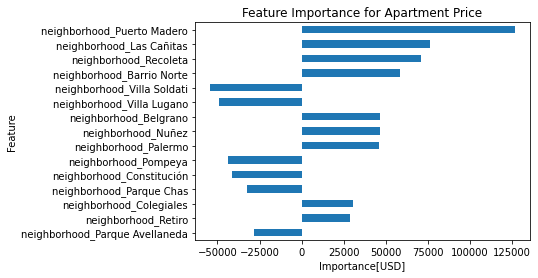

In [183]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance[USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price");

Looking at this bar chart, it can be seen that the poshest neighborhoods in Buenos Aires like Puerto Madero and Recoleta increase the predicted price of an apartment, while more working-class neighborhoods like Villa Soldati and Villa Lugano decrease the predicted price.

# 4. Model Building - Predicting Price with Size, Location and Neighborhood

## Split

In [185]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
y_train = df[target]
X_train = df[features]

## Baseline Model

In [186]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 132392.63
Baseline MAE: 44765.24


## Ridge Regression Model

In [187]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [188]:
y_pred_training = model.predict(X_train)

mae_training = mean_absolute_error(y_train, y_pred_training)

print("Training MAE:", round(mae_training, 2))

Training MAE: 24039.63


In [189]:
X_test = pd.read_excel("buenos-aires-test-features.xlt")

y_pred_test = pd.Series(model.predict(X_test))

y_pred_test.head()

0    229937.809760
1    163661.752509
2     67547.938826
3     63342.970447
4    106537.378780
dtype: float64

## Results 

In [190]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0]) #No interesa que es el index, hay q ponerlo si o si
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $252019.95'

In [191]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);


interactive(children=(IntSlider(value=53, description='area', min=30), FloatSlider(value=-34.598647049939274, …